In [21]:
library(ALDEx2)
library(ggplot2)
library(reshape2)
library(dada2)
library(patchwork)
library(DirichletMultinomial)
library(Biostrings)
library(phyloseq)
library(MASS)
library(fitdistrplus)

In [22]:
taxa_hetero1 <- readRDS("taxa_silva_hetero1.rds")
taxa_oc1     <- readRDS("taxa_silva_oc1.rds")
phylo_hetero1 <- readRDS("phyloseq_object_hetero1.rds")
phylo_oc1     <- readRDS("phyloseq_object_oc_phase1.rds")
taxa_od_wgs   <- read.table("merged_absolute_abundance_od1.tsv", sep = "\t", header = TRUE, row.names = 1)
taxa_oc_wgs   <- read.table("merged_absolute_abundance_oc1.tsv", sep = "\t", header = TRUE, row.names = 1)
seqtab.nochim_oc     <- readRDS("seqtab.nochim_oc.rds")
seqtab.nochim_hetero <- readRDS("seqtab.nochim_hetero.rds")

In [23]:
make_taxonomy_abundance_df <- function(ps, rank_prefixes = c("K", "P", "C", "O", "F", "G")) {
  otu_df <- as.data.frame(otu_table(ps))
  tax_df <- as.data.frame(tax_table(ps))

  if (taxa_are_rows(ps)) otu_df <- t(otu_df)

  shared_taxa <- intersect(colnames(otu_df), rownames(tax_df))
  otu_df <- otu_df[, shared_taxa, drop = FALSE]
  tax_df <- tax_df[shared_taxa, , drop = FALSE]

  tax_df[is.na(tax_df)] <- "unclassified"
  tax_labels <- apply(tax_df, 1, function(row) paste(paste0(rank_prefixes, ":_", row), collapse = "|"))
  colnames(otu_df) <- tax_labels

  return(as.data.frame(otu_df))
}

# Low-abundance Filter
filter_low_abundance <- function(df, min_count = 5, min_prevalence = 0.1) {
  prevalence <- rowSums(df > min_count) / ncol(df)
  df[prevalence >= min_prevalence, , drop = FALSE]
}

# ALDEx2 CLR Transformation
run_aldex_normalization <- function(abundance, cond_label = "default", seed = 42) {
  set.seed(seed)
  abundance[is.na(abundance)] <- 0
  abundance <- abundance[rowSums(abundance) > 0, , drop = FALSE]
  conds <- rep("heterogenic", ncol(abundance))
  aldex_clr <- aldex.clr(abundance, conds = conds, mc.samples = 128, denom = "all", verbose = TRUE)
  clr_matrix <- do.call(cbind, lapply(aldex_clr@analysisData, rowMeans))
  colnames(clr_matrix) <- colnames(abundance)
  rownames(clr_matrix) <- rownames(abundance)
  return(clr_matrix)
}

In [24]:
ps_oc <- phyloseq(otu_table(seqtab.nochim_oc, taxa_are_rows = FALSE), tax_table(taxa_oc1))
ps_hetero <- phyloseq(otu_table(seqtab.nochim_hetero, taxa_are_rows = FALSE), tax_table(taxa_hetero1))

# Add ASV names
taxa_names(ps_oc)     <- paste0("ASV", seq(ntaxa(ps_oc)))
taxa_names(ps_hetero) <- paste0("ASV", seq(ntaxa(ps_hetero)))

# Taxonomic Abundance Tables
tax_abund_oc     <- t(make_taxonomy_abundance_df(ps_oc))
tax_abund_hetero <- t(make_taxonomy_abundance_df(ps_hetero))

In [25]:
taxa_od_wgs_filtered      <- filter_low_abundance(taxa_od_wgs)
taxa_oc_wgs_filtered      <- filter_low_abundance(taxa_oc_wgs)
tax_abund_oc_filtered     <- filter_low_abundance(tax_abund_oc)
tax_abund_hetero_filtered <- filter_low_abundance(tax_abund_hetero)

In [26]:
clr_od_wgs_raw          <- run_aldex_normalization(as.matrix(taxa_od_wgs), "raw_ocean_deep")
clr_oc_wgs_raw          <- run_aldex_normalization(as.matrix(taxa_oc_wgs), "raw_ocean_coastal")
clr_oc_amplicon_raw     <- run_aldex_normalization(as.matrix(tax_abund_oc), "raw_oc_amplicon")
clr_hetero_amplicon_raw <- run_aldex_normalization(as.matrix(tax_abund_hetero), "raw_hetero_amplicon")

conditions vector supplied

operating in serial mode

removed rows with sums equal to zero

computing center with all features

data format is OK

dirichlet samples complete

transformation complete

conditions vector supplied

operating in serial mode

removed rows with sums equal to zero

computing center with all features

data format is OK

dirichlet samples complete

transformation complete

conditions vector supplied

operating in serial mode

removed rows with sums equal to zero

computing center with all features

data format is OK

dirichlet samples complete

transformation complete

conditions vector supplied

operating in serial mode

removed rows with sums equal to zero

computing center with all features

data format is OK

dirichlet samples complete

transformation complete



In [27]:

clr_od_wgs          <- run_aldex_normalization(taxa_od_wgs_filtered, "ocean_deep")
clr_oc_wgs          <- run_aldex_normalization(taxa_oc_wgs_filtered, "ocean_coastal")
clr_oc_amplicon     <- run_aldex_normalization(tax_abund_oc_filtered, "ocean_coastal_amp")
clr_hetero_amplicon <- run_aldex_normalization(tax_abund_hetero_filtered, "hetero_amp")

conditions vector supplied



operating in serial mode

removed rows with sums equal to zero

computing center with all features

data format is OK

dirichlet samples complete

transformation complete

conditions vector supplied

operating in serial mode

removed rows with sums equal to zero

computing center with all features

data format is OK

dirichlet samples complete

transformation complete

conditions vector supplied

operating in serial mode

removed rows with sums equal to zero

computing center with all features

data format is OK

dirichlet samples complete

transformation complete

conditions vector supplied

operating in serial mode

removed rows with sums equal to zero

computing center with all features

data format is OK

dirichlet samples complete

transformation complete



In [28]:
plot_clr_boxplot <- function(clr_matrix, title_prefix = "") {
  clr_long <- melt(clr_matrix, varnames = c("Feature", "Sample"), value.name = "CLR_Value")
  p <- ggplot(clr_long, aes(x = Sample, y = CLR_Value)) +
    geom_boxplot(outlier.size = 0.5) +
    theme_bw() +
    theme(axis.text.x = element_text(angle = 90, hjust = 1)) +
    labs(title = paste0(title_prefix, ": CLR Abundances per Sample"),
         y = "CLR Abundance", x = "Sample")
  return(p)
}

In [29]:
plot_clr_mean_variance <- function(clr_matrix, title_prefix = "") {
  clr_means <- rowMeans(clr_matrix)
  clr_vars  <- apply(clr_matrix, 1, var)
  p <- ggplot(data.frame(mean = clr_means, var = clr_vars), aes(x = mean, y = var)) +
    geom_point(color = "blue", size = 1) +
    scale_x_log10() + scale_y_log10() +
    theme_bw() +
    labs(title = paste0(title_prefix, ": Mean-Variance Plot"),
         x = "Mean CLR Abundance", y = "Variance")
  return(p)
}

In [30]:
plot_combined_mv <- function(clr_list, n = 10, seed = 123, title = "Mean vs Variance Plot (Subsampled)") {
  set.seed(seed)
  
  mv_df <- data.frame()

  for (domain_name in names(clr_list)) {
    clr_matrix <- clr_list[[domain_name]]
    
    # Subsample up to n samples per domain
    sample_subset <- sample(colnames(clr_matrix), min(n, ncol(clr_matrix)))
    clr_sub <- clr_matrix[, sample_subset, drop = FALSE]
    
    # Compute per-feature mean and variance (rows = features)
    feature_means <- rowMeans(clr_sub)
    feature_vars  <- apply(clr_sub, 1, var)

    mv_domain_df <- data.frame(
      Feature = rownames(clr_sub),
      Mean = feature_means,
      Variance = feature_vars,
      Domain = domain_name
    )
    
    mv_df <- rbind(mv_df, mv_domain_df)
  }
  
  ggplot(mv_df, aes(x = Mean, y = Variance, color = Domain)) +
    geom_point(alpha = 0.6, size = 2) +
    theme_minimal() +
    labs(title = title, x = "Mean CLR Abundance (per Feature)", y = "Variance (per Feature)") +
    scale_color_brewer(palette = "Set1") +
    theme(legend.title = element_text(size = 10),
          legend.text = element_text(size = 9))
}


In [35]:
plot_all_distributions <- function(clr_matrix, title_prefix = "") {
  v <- as.vector(clr_matrix)
  v <- v[!is.na(v)]
  v_pos <- v[v > 0]  # strictly positive for some dists
  
  n <- length(v_pos)
  probs <- ppoints(n)
  
  plots <- list()

  # === QQ Normal ===
  plots[["Normal"]] <- ggplot(data.frame(sample = sort(v_pos),
                                         theoretical = qqnorm(v_pos, plot.it = FALSE)$x),
                              aes(sample = sample)) +
    stat_qq() + stat_qq_line(col = "red") +
    theme_bw() +
    labs(title = paste0(title_prefix, ": Normal"),
         x = "Theoretical Quantiles", y = "Sample Quantiles")

  # === QQ Poisson ===
  lambda <- mean(v_pos)
  theo_pois <- qpois(probs, lambda)
  plots[["Poisson"]] <- ggplot(data.frame(sample = sort(v_pos), theoretical = sort(theo_pois)),
                               aes(x = theoretical, y = sample)) +
    geom_point(size = 1) +
    geom_abline(slope = 1, intercept = 0, col = "red") +
    theme_bw() +
    labs(title = paste0(title_prefix, ": Poisson(λ=", round(lambda,2), ")"),
         x = "Theoretical Quantiles", y = "Sample Quantiles")

  # === QQ Log-Normal ===
  log_v <- log(v_pos)
  plots[["LogNormal"]] <- ggplot(data.frame(sample = sort(log_v),
                                            theoretical = qqnorm(log_v, plot.it = FALSE)$x),
                                 aes(sample = sample)) +
    stat_qq() + stat_qq_line(col = "red") +
    theme_bw() +
    labs(title = paste0(title_prefix, ": Log-Normal"),
         x = "Theoretical Quantiles", y = "Log Sample Quantiles")

  # === QQ Negative Binomial ===
  nb_fit <- tryCatch({
    fitdistr(round(v_pos), "Negative Binomial")
  }, error = function(e) NULL)
  
  if (!is.null(nb_fit)) {
    size <- nb_fit$estimate["size"]
    mu <- nb_fit$estimate["mu"]
    theo_nb <- qnbinom(probs, size = size, mu = mu)
    plots[["NegBinom"]] <- ggplot(data.frame(sample = sort(v_pos), theoretical = sort(theo_nb)),
                                  aes(x = theoretical, y = sample)) +
      geom_point(size = 1) +
      geom_abline(slope = 1, intercept = 0, col = "red") +
      theme_bw() +
      labs(title = paste0(title_prefix, ": NegBinom(mu=", round(mu,1), ", size=", round(size,1), ")"),
           x = "Theoretical Quantiles", y = "Sample Quantiles")
  }

  # === QQ Gamma ===
  shape <- mean(v_pos)^2 / var(v_pos)
  rate <- mean(v_pos) / var(v_pos)
  theo_gamma <- qgamma(probs, shape = shape, rate = rate)
  plots[["Gamma"]] <- ggplot(data.frame(sample = sort(v_pos), theoretical = sort(theo_gamma)),
                             aes(x = theoretical, y = sample)) +
    geom_point(size = 1) +
    geom_abline(slope = 1, intercept = 0, col = "red") +
    theme_bw() +
    labs(title = paste0(title_prefix, ": Gamma"),
         x = "Theoretical Quantiles", y = "Sample Quantiles")

  # === QQ Log-Cauchy ===
  cauchy_fit <- tryCatch({
    fitdist(log_v, "cauchy")
  }, error = function(e) NULL)
  
  if (!is.null(cauchy_fit)) {
    location <- cauchy_fit$estimate["location"]
    scale <- cauchy_fit$estimate["scale"]
    theo_lc <- qcauchy(probs, location, scale)
    plots[["Log-Cauchy"]] <- ggplot(data.frame(sample = sort(log_v), theoretical = sort(theo_lc)),
                                    aes(x = theoretical, y = sample)) +
      geom_point(size = 1) +
      geom_abline(slope = 1, intercept = 0, col = "red") +
      theme_bw() +
      labs(title = paste0(title_prefix, ": Log-Cauchy"),
           x = "Theoretical Quantiles", y = "Log Sample Quantiles")
  }

  # === QQ Weibull ===
  weibull_fit <- tryCatch({
    fitdist(v_pos, "weibull")
  }, error = function(e) NULL)

  if (!is.null(weibull_fit)) {
    shape_w <- weibull_fit$estimate["shape"]
    scale_w <- weibull_fit$estimate["scale"]
    theo_weibull <- qweibull(probs, shape = shape_w, scale = scale_w)
    plots[["Weibull"]] <- ggplot(data.frame(sample = sort(v_pos), theoretical = sort(theo_weibull)),
                                 aes(x = theoretical, y = sample)) +
      geom_point(size = 1) +
      geom_abline(slope = 1, intercept = 0, col = "red") +
      theme_bw() +
      labs(title = paste0(title_prefix, ": Weibull"),
           x = "Theoretical Quantiles", y = "Sample Quantiles")
  }
return(plots)
}

 # Mean vs variance with normalization before filtration

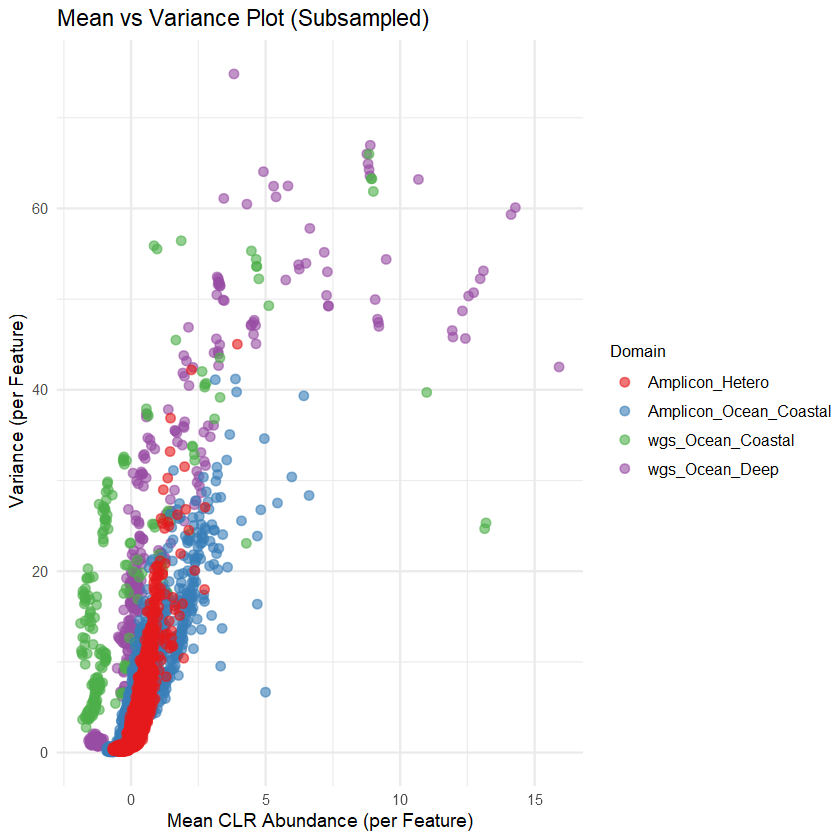

In [49]:
raw_list_filtered <- list(
  wgs_Ocean_Deep = clr_od_wgs_raw,
  wgs_Ocean_Coastal = clr_oc_wgs_raw,
  Amplicon_Ocean_Coastal = clr_oc_amplicon_raw,
  Amplicon_Hetero = clr_hetero_amplicon_raw
)

plot_combined_mv(raw_list_filtered)

# Mean vs variance without normalization before filtration

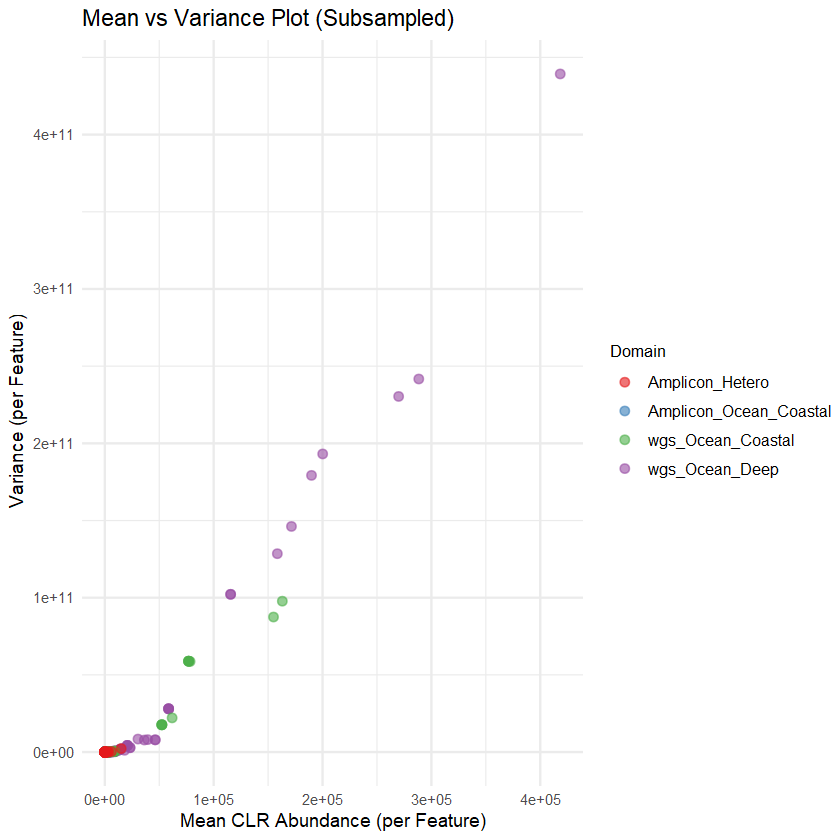

In [46]:
raw_list_non_filtered <- list(
  wgs_Ocean_Deep = taxa_od_wgs,
  wgs_Ocean_Coastal = taxa_oc_wgs,
  Amplicon_Ocean_Coastal = tax_abund_oc,
  Amplicon_Hetero = tax_abund_hetero
)

plot_combined_mv(raw_list_non_filtered)

# Mean vs variance after filtration and normalization

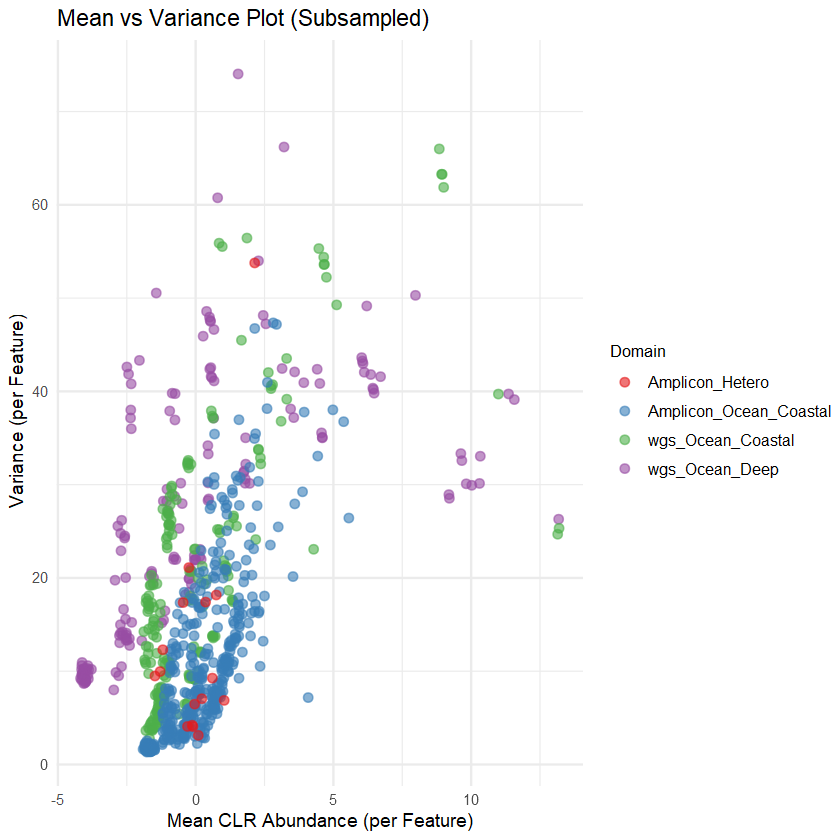

In [ ]:
clr_list_filtered <- list(
  wgs_Ocean_Deep = clr_od_wgs_filtered,
  wgs_Ocean_Coastal = clr_oc_wgs_filtered,
  Amplicon_Ocean_Coastal = clr_oc_amp_filtered,
  Amplicon_Hetero = clr_hetero_amp_filtered
)

plot_combined_mv(clr_list_filtered)

# q-q for non- filtered and non-normalized

Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'Raw Ocean Deep (WGS): Poisson(λ=63922.15)' in 'mbcsToSbcs': dot substituted for <ce>"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'Raw Ocean Deep (WGS): Poisson(λ=63922.15)' in 'mbcsToSbcs': dot substituted for <bb>"
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'Raw Ocean Deep (WGS): Poisson(λ=63922.15)' in 'mbcsToSbcs': dot substituted for <ce>"
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'Raw Ocean Deep (WGS): Poisson(λ=63922.15)' in 'mbcsToSbcs': dot substituted for <bb>"
Warning message in densfun(x, parm[1], parm[2], ...):
"NaNs produced"
Warning message in densfun(x, parm[1], parm[2], ...):
"NaNs produced"
Warning message in densfun(x, parm[1], parm[2], ...):
"NaNs produced"
Warning message 

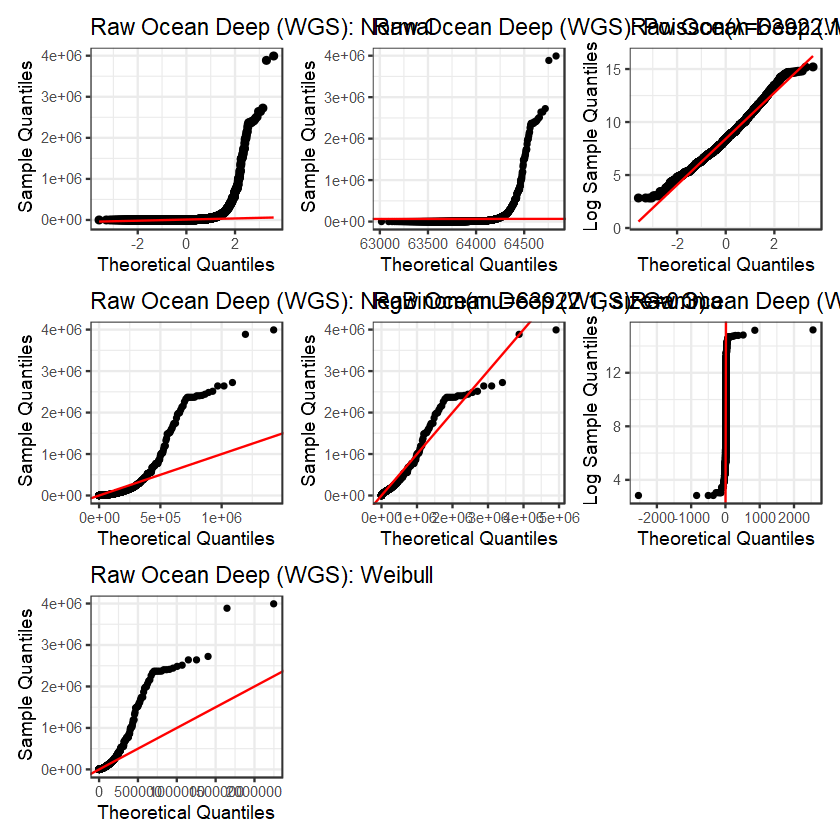

Warning message in densfun(x, parm[1], parm[2], ...):
"NaNs produced"
Warning message in densfun(x, parm[1], parm[2], ...):
"NaNs produced"
Warning message in densfun(x, parm[1], parm[2], ...):
"NaNs produced"
Warning message in densfun(x, parm[1], parm[2], ...):
"NaNs produced"
Warning message in densfun(x, parm[1], parm[2], ...):
"NaNs produced"
Warning message in densfun(x, parm[1], parm[2], ...):
"NaNs produced"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'Raw Ocean Coastal (Amplicon): Poisson(λ=99.47)' in 'mbcsToSbcs': dot substituted for <ce>"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'Raw Ocean Coastal (Amplicon): Poisson(λ=99.47)' in 'mbcsToSbcs': dot substituted for <bb>"
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'Raw Ocean Coastal (Amplicon): Poisson(λ=99.47)' in 'mbcsToSbcs': dot substitu

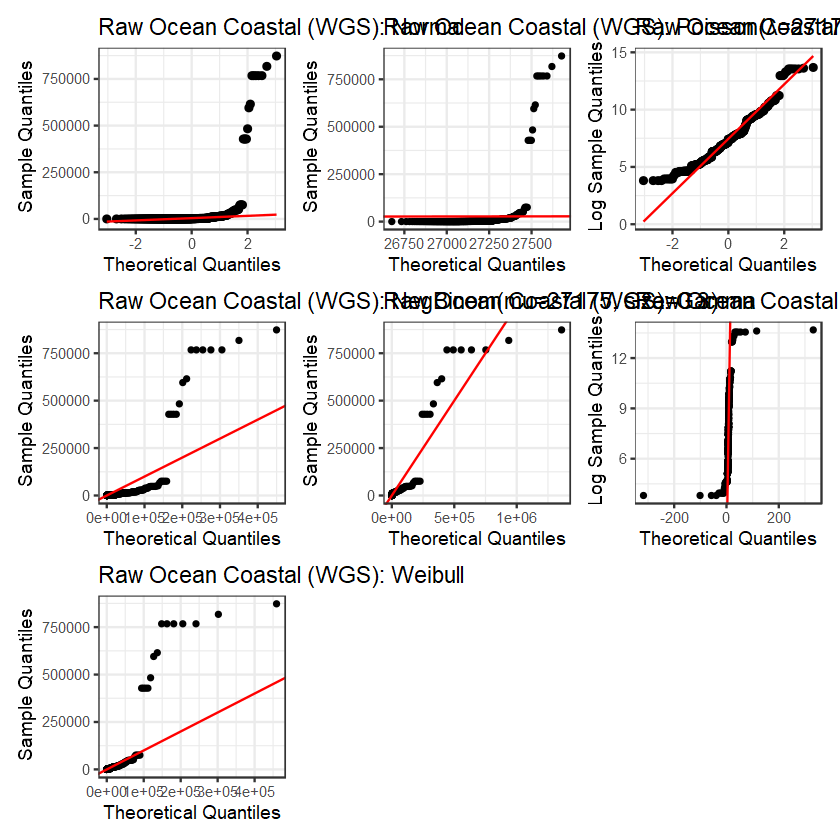

Warning message in densfun(x, parm[1], parm[2], ...):
"NaNs produced"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'Raw Hetero (Amplicon): Poisson(λ=118.75)' in 'mbcsToSbcs': dot substituted for <ce>"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'Raw Hetero (Amplicon): Poisson(λ=118.75)' in 'mbcsToSbcs': dot substituted for <bb>"
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'Raw Hetero (Amplicon): Poisson(λ=118.75)' in 'mbcsToSbcs': dot substituted for <ce>"
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'Raw Hetero (Amplicon): Poisson(λ=118.75)' in 'mbcsToSbcs': dot substituted for <bb>"


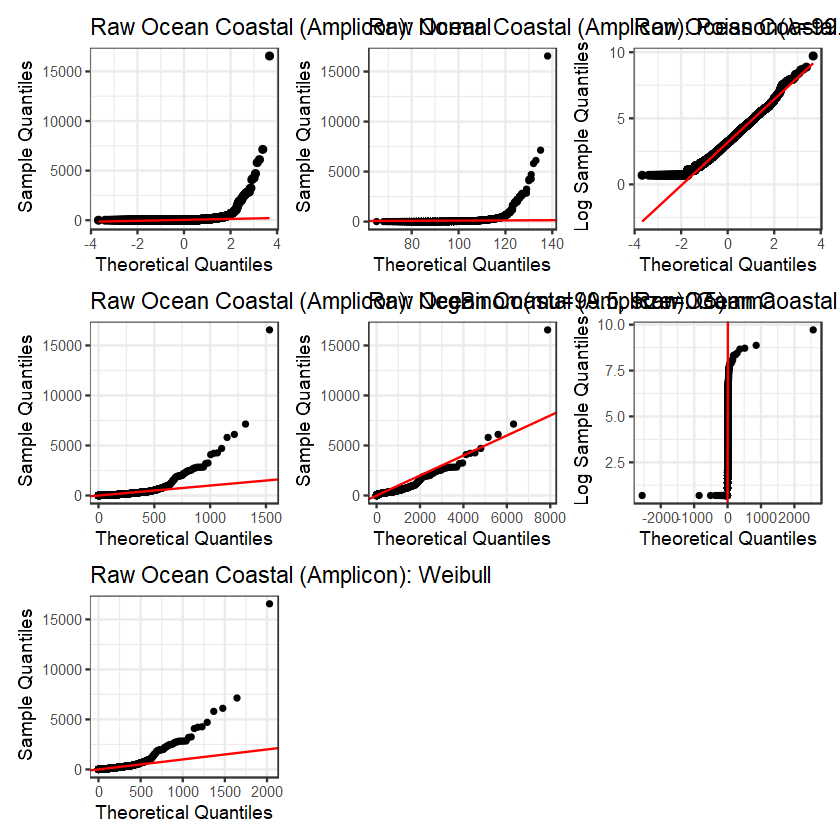

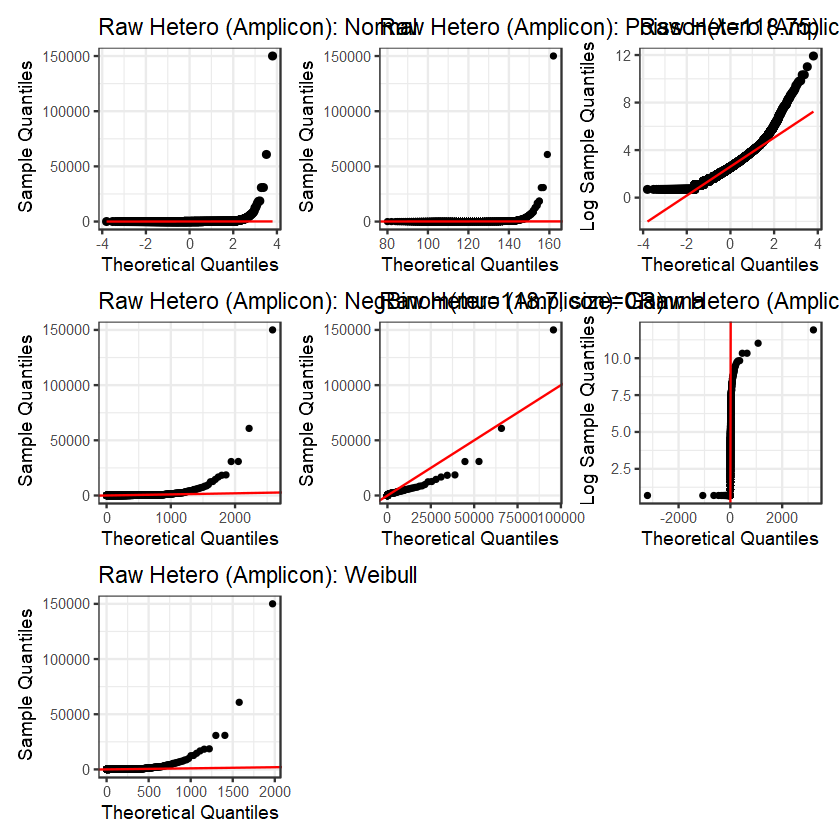

In [ ]:
wrap_plots(plot_all_distributions(as.matrix(taxa_od_wgs), "Raw Ocean Deep (WGS)"), ncol = 3, nrow = 3)
wrap_plots(plot_all_distributions(as.matrix(taxa_oc_wgs), "Raw Ocean Coastal (WGS)"), ncol = 3, nrow = 3)
wrap_plots(plot_all_distributions(as.matrix(tax_abund_oc), "Raw Ocean Coastal (Amplicon)"), ncol = 3, nrow = 3)
wrap_plots(plot_all_distributions(as.matrix(tax_abund_hetero), "Raw Hetero (Amplicon)"), ncol = 3, nrow = 3)



# q-q plots for data filtered but not normalized

Warning message in densfun(x, parm[1], parm[2], ...):
"NaNs produced"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'Filtered Ocean Deep (WGS): Poisson(λ=83798.07)' in 'mbcsToSbcs': dot substituted for <ce>"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'Filtered Ocean Deep (WGS): Poisson(λ=83798.07)' in 'mbcsToSbcs': dot substituted for <bb>"
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'Filtered Ocean Deep (WGS): Poisson(λ=83798.07)' in 'mbcsToSbcs': dot substituted for <ce>"
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'Filtered Ocean Deep (WGS): Poisson(λ=83798.07)' in 'mbcsToSbcs': dot substituted for <bb>"
Warning message in densfun(x, parm[1], parm[2], ...):
"NaNs produced"
Warning message in densfun(x, parm[1], parm[2], ...):
"NaNs produc

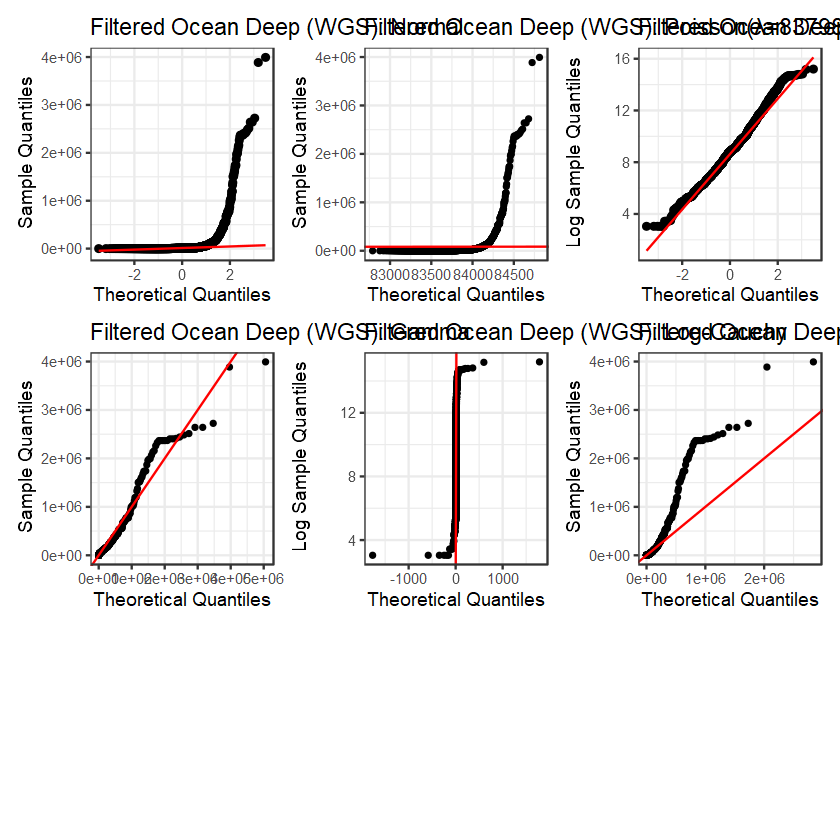

Warning message in densfun(x, parm[1], parm[2], ...):
"NaNs produced"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'Filtered Ocean Coastal (Amplicon): Poisson(λ=157.49)' in 'mbcsToSbcs': dot substituted for <ce>"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'Filtered Ocean Coastal (Amplicon): Poisson(λ=157.49)' in 'mbcsToSbcs': dot substituted for <bb>"
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'Filtered Ocean Coastal (Amplicon): Poisson(λ=157.49)' in 'mbcsToSbcs': dot substituted for <ce>"
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'Filtered Ocean Coastal (Amplicon): Poisson(λ=157.49)' in 'mbcsToSbcs': dot substituted for <bb>"


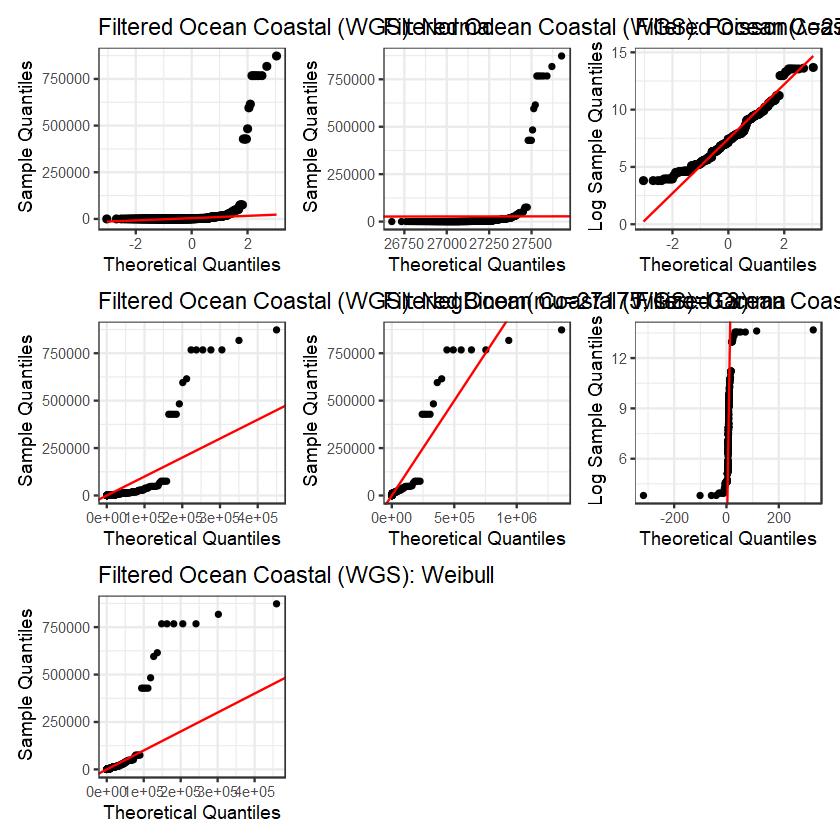

Warning message in densfun(x, parm[1], parm[2], ...):
"NaNs produced"
Warning message in densfun(x, parm[1], parm[2], ...):
"NaNs produced"
Warning message in densfun(x, parm[1], parm[2], ...):
"NaNs produced"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'Filtered Hetero (Amplicon): Poisson(λ=818.33)' in 'mbcsToSbcs': dot substituted for <ce>"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'Filtered Hetero (Amplicon): Poisson(λ=818.33)' in 'mbcsToSbcs': dot substituted for <bb>"
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'Filtered Hetero (Amplicon): Poisson(λ=818.33)' in 'mbcsToSbcs': dot substituted for <ce>"
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'Filtered Hetero (Amplicon): Poisson(λ=818.33)' in 'mbcsToSbcs': dot substituted for <bb>"


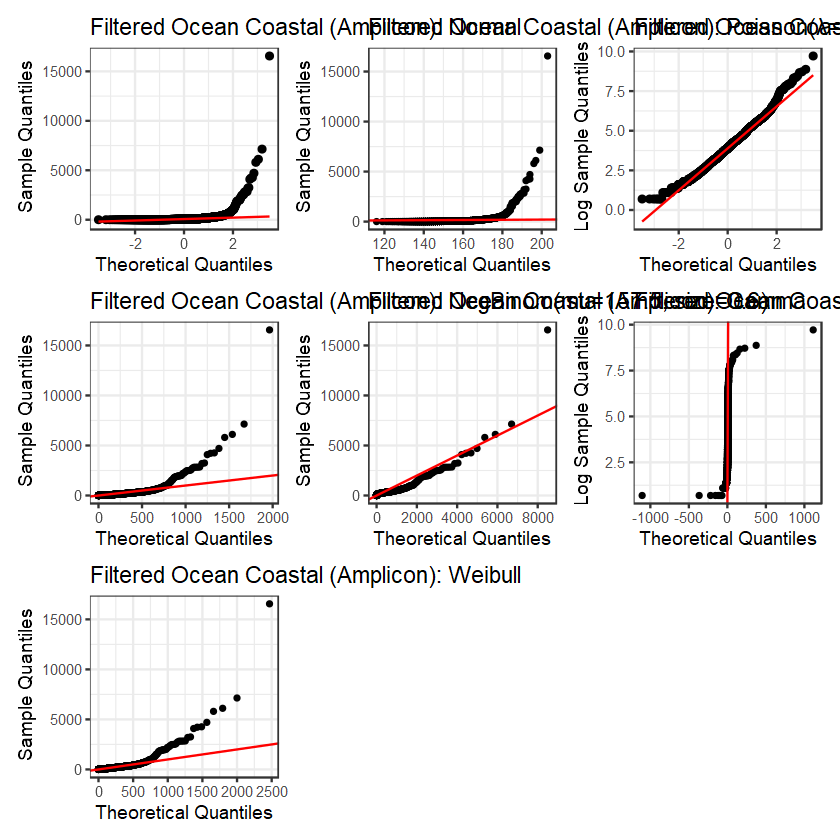

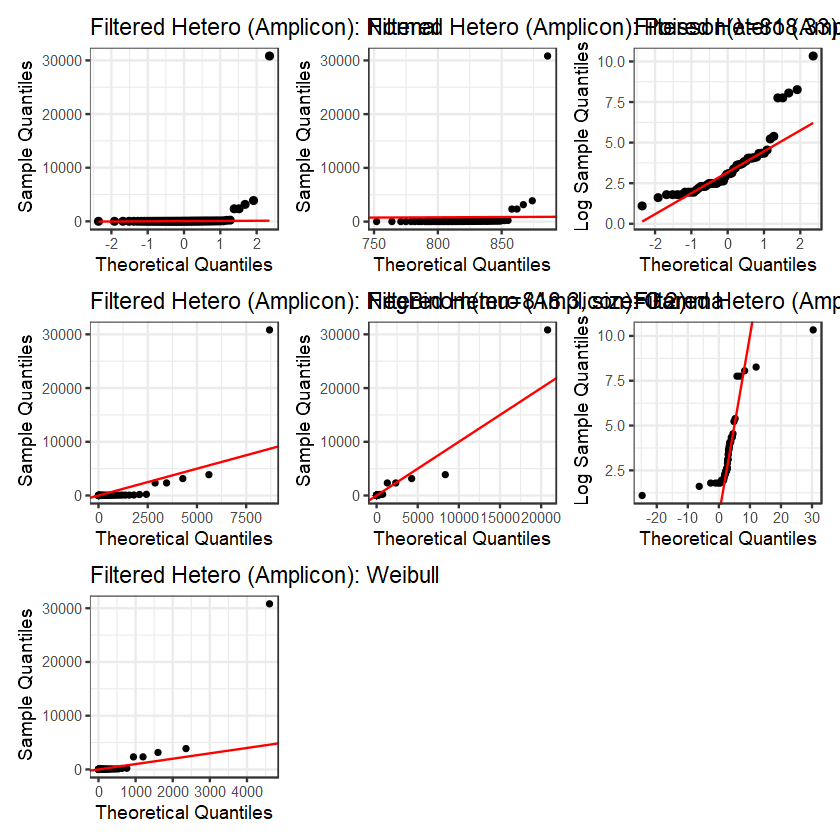

In [37]:
wrap_plots(plot_all_distributions(as.matrix(taxa_od_wgs_filtered), "Filtered Ocean Deep (WGS)"), ncol = 3, nrow = 3)
wrap_plots(plot_all_distributions(as.matrix(taxa_oc_wgs_filtered), "Filtered Ocean Coastal (WGS)"), ncol = 3, nrow = 3)
wrap_plots(plot_all_distributions(as.matrix(tax_abund_oc_filtered), "Filtered Ocean Coastal (Amplicon)"), ncol = 3, nrow = 3)
wrap_plots(plot_all_distributions(as.matrix(tax_abund_hetero_filtered), "Filtered Hetero (Amplicon)"), ncol = 3, nrow = 3)


# q-q plots for normalized but not filtered data 

Warning message in densfun(x, parm[1], parm[2], ...):
"NaNs produced"
Warning message in densfun(x, parm[1], parm[2], ...):
"NaNs produced"
Warning message in densfun(x, parm[1], parm[2], ...):
"NaNs produced"
Warning message in densfun(x, parm[1], parm[2], ...):
"NaNs produced"
Warning message in densfun(x, parm[1], parm[2], ...):
"NaNs produced"
Warning message in densfun(x, parm[1], parm[2], ...):
"NaNs produced"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'CLR Ocean Deep (WGS): Poisson(λ=6.92)' in 'mbcsToSbcs': dot substituted for <ce>"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'CLR Ocean Deep (WGS): Poisson(λ=6.92)' in 'mbcsToSbcs': dot substituted for <bb>"
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'CLR Ocean Deep (WGS): Poisson(λ=6.92)' in 'mbcsToSbcs': dot substituted for <ce>"
Warning messa

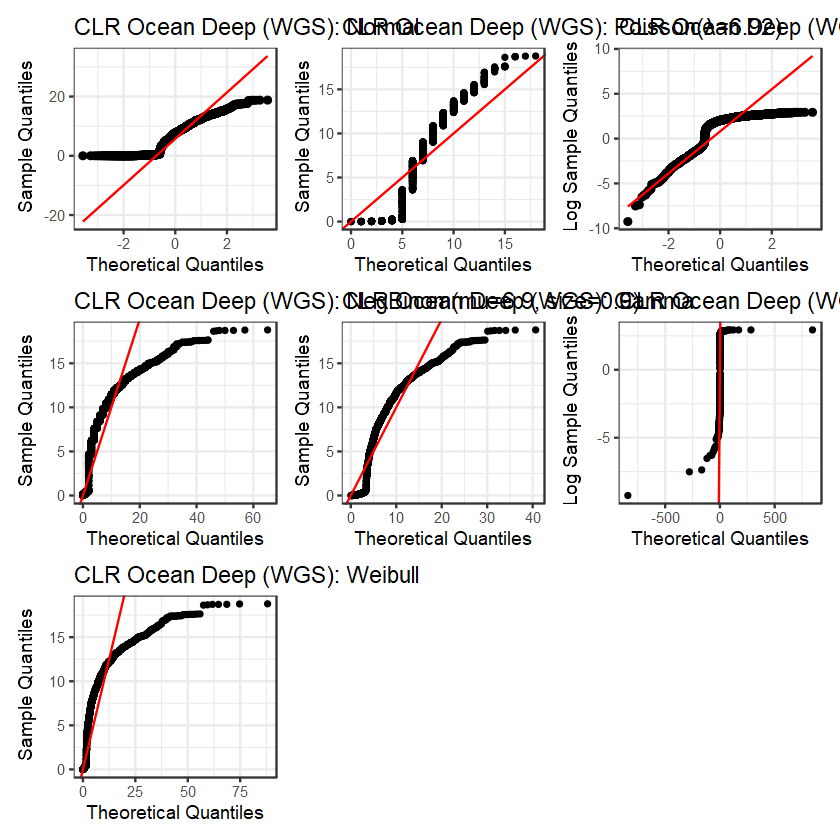

Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'CLR Ocean Coastal (Amplicon): Poisson(λ=5.79)' in 'mbcsToSbcs': dot substituted for <ce>"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'CLR Ocean Coastal (Amplicon): Poisson(λ=5.79)' in 'mbcsToSbcs': dot substituted for <bb>"
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'CLR Ocean Coastal (Amplicon): Poisson(λ=5.79)' in 'mbcsToSbcs': dot substituted for <ce>"
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'CLR Ocean Coastal (Amplicon): Poisson(λ=5.79)' in 'mbcsToSbcs': dot substituted for <bb>"


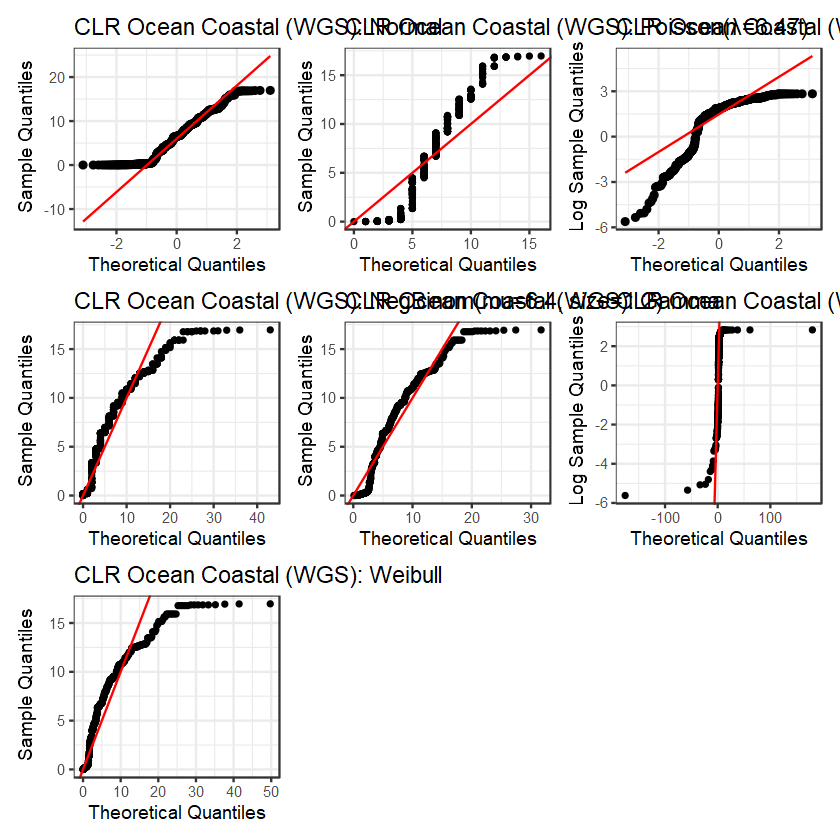

Warning message in densfun(x, parm[1], parm[2], ...):
"NaNs produced"
Warning message in densfun(x, parm[1], parm[2], ...):
"NaNs produced"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'CLR Hetero (Amplicon): Poisson(λ=2.79)' in 'mbcsToSbcs': dot substituted for <ce>"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'CLR Hetero (Amplicon): Poisson(λ=2.79)' in 'mbcsToSbcs': dot substituted for <bb>"
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'CLR Hetero (Amplicon): Poisson(λ=2.79)' in 'mbcsToSbcs': dot substituted for <ce>"
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'CLR Hetero (Amplicon): Poisson(λ=2.79)' in 'mbcsToSbcs': dot substituted for <bb>"


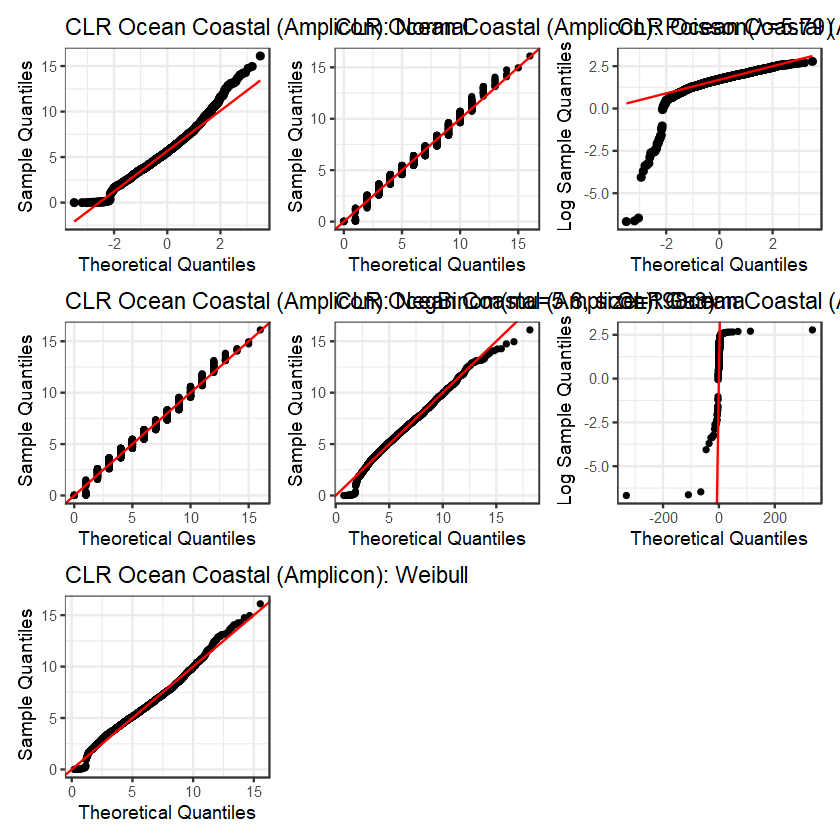

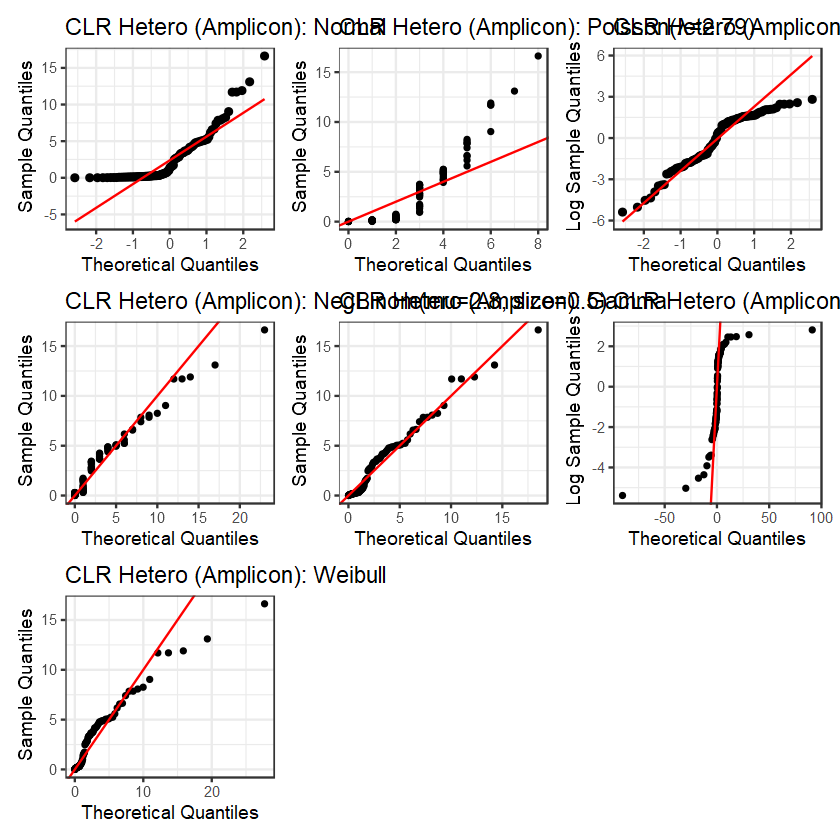

In [ ]:
wrap_plots(plot_all_distributions(clr_od_wgs, "CLR Ocean Deep (WGS)"), ncol = 3, nrow = 3)
wrap_plots(plot_all_distributions(clr_oc_wgs, "CLR Ocean Coastal (WGS)"), ncol = 3, nrow = 3)
wrap_plots(plot_all_distributions(clr_oc_amplicon, "CLR Ocean Coastal (Amplicon)"), ncol = 3, nrow = 3)
wrap_plots(plot_all_distributions(clr_hetero_amplicon, "CLR Hetero (Amplicon)"), ncol = 3, nrow = 3)

# q-q plots for normalized and filtered data

Warning message in densfun(x, parm[1], parm[2], ...):
"NaNs produced"
Warning message in densfun(x, parm[1], parm[2], ...):
"NaNs produced"
Warning message in densfun(x, parm[1], parm[2], ...):
"NaNs produced"
Warning message in densfun(x, parm[1], parm[2], ...):
"NaNs produced"
Warning message in densfun(x, parm[1], parm[2], ...):
"NaNs produced"
Warning message in densfun(x, parm[1], parm[2], ...):
"NaNs produced"
Warning message in densfun(x, parm[1], parm[2], ...):
"NaNs produced"
Warning message in densfun(x, parm[1], parm[2], ...):
"NaNs produced"
Warning message in densfun(x, parm[1], parm[2], ...):
"NaNs produced"
Warning message in densfun(x, parm[1], parm[2], ...):
"NaNs produced"
Warning message in densfun(x, parm[1], parm[2], ...):
"NaNs produced"
Warning message in densfun(x, parm[1], parm[2], ...):
"NaNs produced"
Warning message in densfun(x, parm[1], parm[2], ...):
"NaNs produced"
Warning message in densfun(x, parm[1], parm[2], ...):
"NaNs produced"
Warning message in d

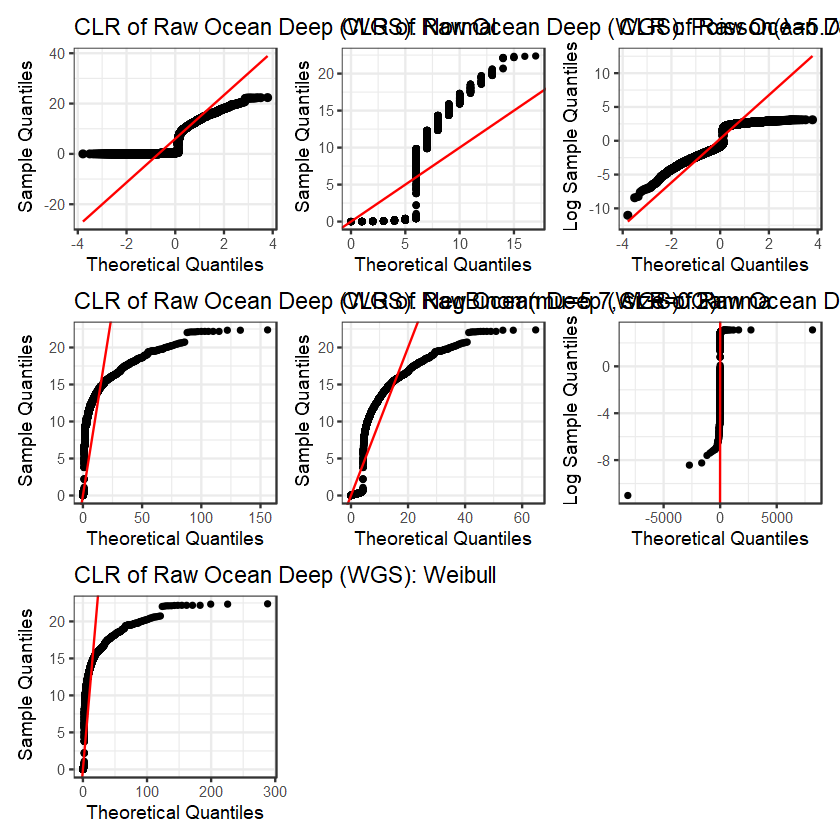

Warning message in densfun(x, parm[1], parm[2], ...):
"NaNs produced"
Warning message in densfun(x, parm[1], parm[2], ...):
"NaNs produced"
Warning message in densfun(x, parm[1], parm[2], ...):
"NaNs produced"
Warning message in densfun(x, parm[1], parm[2], ...):
"NaNs produced"
Warning message in densfun(x, parm[1], parm[2], ...):
"NaNs produced"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'CLR of Raw Ocean Coastal (Amplicon): Poisson(λ=4.13)' in 'mbcsToSbcs': dot substituted for <ce>"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'CLR of Raw Ocean Coastal (Amplicon): Poisson(λ=4.13)' in 'mbcsToSbcs': dot substituted for <bb>"
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
"conversion failure on 'CLR of Raw Ocean Coastal (Amplicon): Poisson(λ=4.13)' in 'mbcsToSbcs': dot substituted for <ce>"
Warning message in grid.Call.graphics(

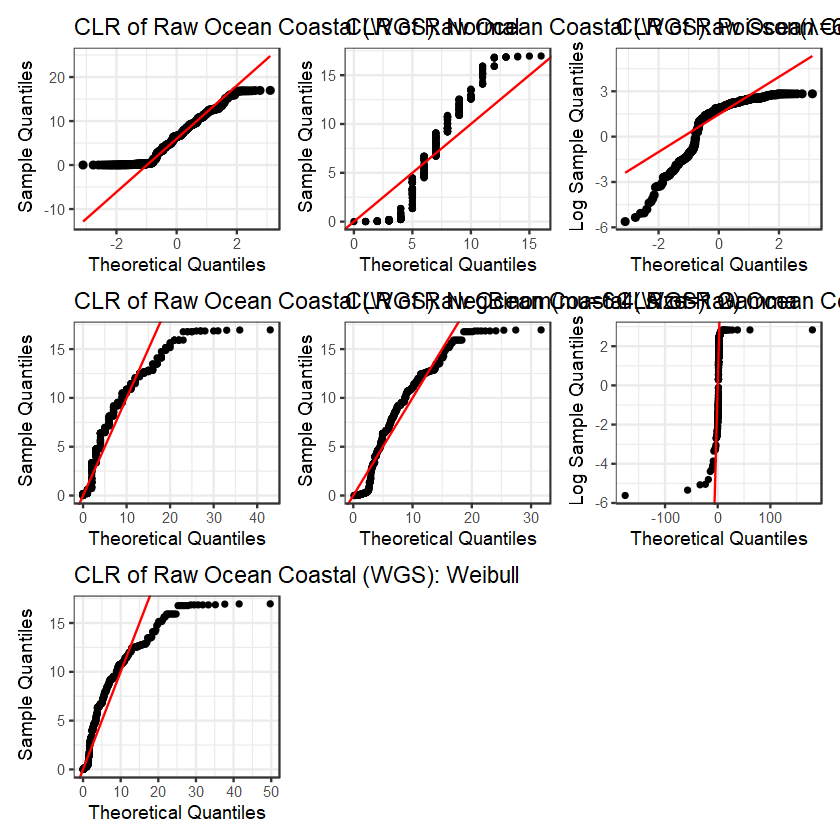

Warning message in densfun(x, parm[1], parm[2], ...):
"NaNs produced"
Warning message in densfun(x, parm[1], parm[2], ...):
"NaNs produced"
Warning message in densfun(x, parm[1], parm[2], ...):
"NaNs produced"
Warning message in densfun(x, parm[1], parm[2], ...):
"NaNs produced"
Warning message in densfun(x, parm[1], parm[2], ...):
"NaNs produced"
Warning message in densfun(x, parm[1], parm[2], ...):
"NaNs produced"
Warning message in densfun(x, parm[1], parm[2], ...):
"NaNs produced"
Warning message in densfun(x, parm[1], parm[2], ...):
"NaNs produced"
Warning message in densfun(x, parm[1], parm[2], ...):
"NaNs produced"
Warning message in densfun(x, parm[1], parm[2], ...):
"NaNs produced"
Warning message in densfun(x, parm[1], parm[2], ...):
"NaNs produced"
Warning message in densfun(x, parm[1], parm[2], ...):
"NaNs produced"
Warning message in densfun(x, parm[1], parm[2], ...):
"NaNs produced"
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"convers

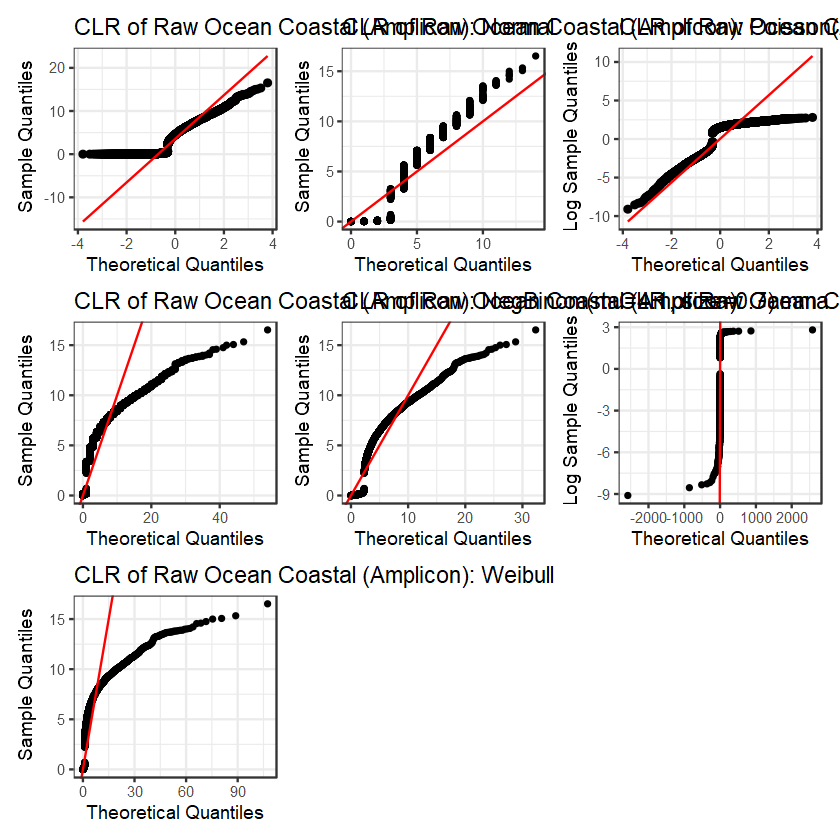

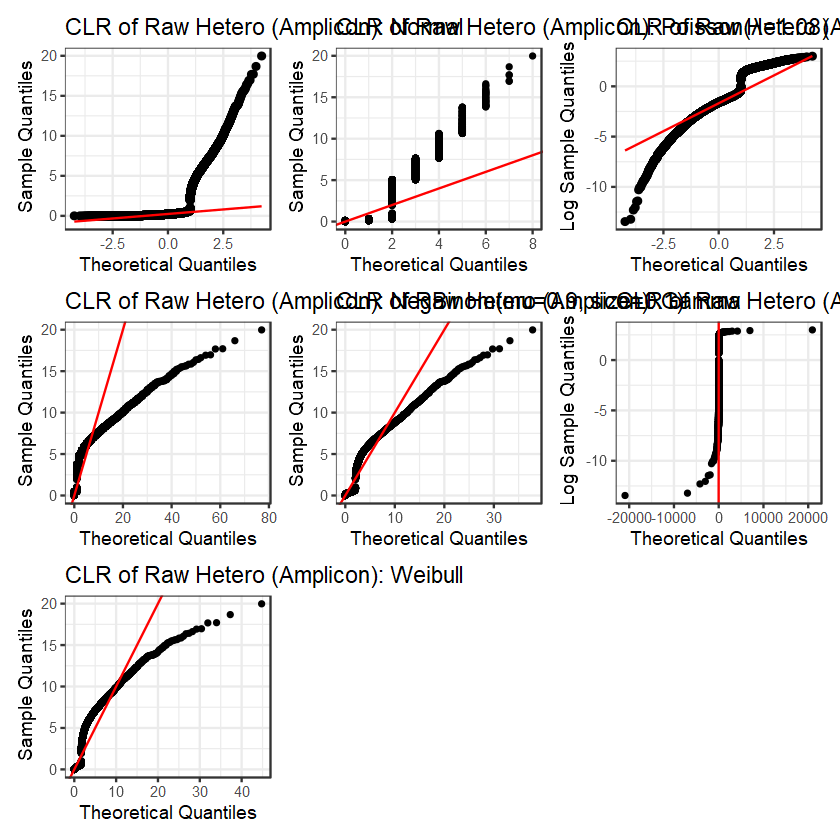

In [ ]:
wrap_plots(plot_all_distributions(clr_od_wgs_raw, "CLR of Raw Ocean Deep (WGS)"), ncol = 3, nrow = 3)
wrap_plots(plot_all_distributions(clr_oc_wgs_raw, "CLR of Raw Ocean Coastal (WGS)"), ncol = 3, nrow = 3)
wrap_plots(plot_all_distributions(clr_oc_amplicon_raw, "CLR of Raw Ocean Coastal (Amplicon)"), ncol = 3, nrow = 3)
wrap_plots(plot_all_distributions(clr_hetero_amplicon_raw, "CLR of Raw Hetero (Amplicon)"), ncol = 3, nrow = 3)